In [8]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [9]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [66]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [11]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [13]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [15]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results_across_mice_SW19-35.npy', dict_results_across_mice)

In [16]:
dict_results_across_mice = np.load('dict_results_across_mice_SW19-35-300.npy', allow_pickle=True).item()

# List areas with null cell count

In [17]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [20]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [23]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam',
  'SW23_Fam',
  'SW21_Fam',
  'SW29_Fam',
  'SW33_Fam',
  'SW35_Fam']}

# Calculate cell count across experimental groups

In [25]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [29]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0933802,0.465098,0.22456
1,Primary motor area,0.351738,0.170507,0.795644
2,Secondary motor area,0.179054,0.187534,0.822085
3,Primary somatosensory area,0.171589,0.170319,0.820392
4,Supplemental somatosensory area,0.09728,0.13664,0.4599
...,...,...,...,...
293,Flocculus,0.155804,0.452446,0.0936265
294,Fastigial nucleus,0.103888,0.103888,NaN
295,Interposed nucleus,0.772746,0.0420034,0.340893
296,Dentate nucleus,0.581064,0.296665,0.340893


In [67]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000289924
Medial amygdalar nucleus,0.000940658
Cortical amygdalar area,0.00214934
Ventral premammillary nucleus,0.00337135
Piriform-amygdalar area,0.00365834
Parastrial nucleus,0.00893705
Paraventricular hypothalamic nucleus descending division,0.021487
Visceral area,0.0417686
Globus pallidus internal segment,0.0649699


In [32]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00676547
Globus pallidus internal segment,0.00842596
Posterior amygdalar nucleus,0.0137814
Ventral premammillary nucleus,0.0174217
Piriform-amygdalar area,0.0200109
Cortical amygdalar area,0.0413282
Interposed nucleus,0.0420034
Periventricular hypothalamic nucleus posterior part,0.0523048
Bed nucleus of the anterior commissure,0.0684783


In [33]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.0136946
Paraventricular hypothalamic nucleus descending division,0.0191556
Paraflocculus,0.0404435
Septohippocampal nucleus,0.0493322
Posterior hypothalamic nucleus,0.0593491
Superior colliculus sensory related,0.0640663
Anterodorsal nucleus,0.0871695
Flocculus,0.0936265
Visceral area,0.0999235


## Mann Whitney Test for comparison across groups

In [34]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0849649,0.232096,0.188821
1,Primary motor area,0.117667,0.180108,0.405091
2,Secondary motor area,0.157651,0.136115,0.468093
3,Primary somatosensory area,0.0854518,0.291512,0.287587
4,Supplemental somatosensory area,0.0603454,0.291512,0.287587
...,...,...,...,...
293,Flocculus,0.203508,0.5,0.045206
294,Fastigial nucleus,0.0672083,0.0672083,NaN
295,Interposed nucleus,0.169919,0.023791,0.202328
296,Dentate nucleus,0.446148,0.180655,0.202328


In [68]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial amygdalar nucleus,0.00398471
Posterior amygdalar nucleus,0.00405656
Cortical amygdalar area,0.00685542
Parastrial nucleus,0.0103353
Piriform-amygdalar area,0.0112394
Paraventricular hypothalamic nucleus descending division,0.0138709
Ventral posterior complex of the thalamus,0.0201481
Subthalamic nucleus,0.0220652
Globus pallidus internal segment,0.0330077


In [37]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Globus pallidus internal segment,0.00792938
Medial amygdalar nucleus,0.0085552
Piriform-amygdalar area,0.01405
Ventral premammillary nucleus,0.01405
Interposed nucleus,0.023791
Bed nucleus of the anterior commissure,0.0243304
Parapyramidal nucleus,0.0247303
Periventricular hypothalamic nucleus posterior part,0.033632
Posterior amygdalar nucleus,0.033632


In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00283952
Paraventricular hypothalamic nucleus descending division,0.0101203
Posterior hypothalamic nucleus,0.0226638
Superior colliculus sensory related,0.0226638
Nucleus raphe magnus,0.0287676
Paraflocculus,0.032305
Anteromedial visual area,0.0327761
Gigantocellular reticular nucleus,0.0327761
Septohippocampal nucleus,0.0352664


## Calculate cross corr across groups per area on cell count

In [69]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

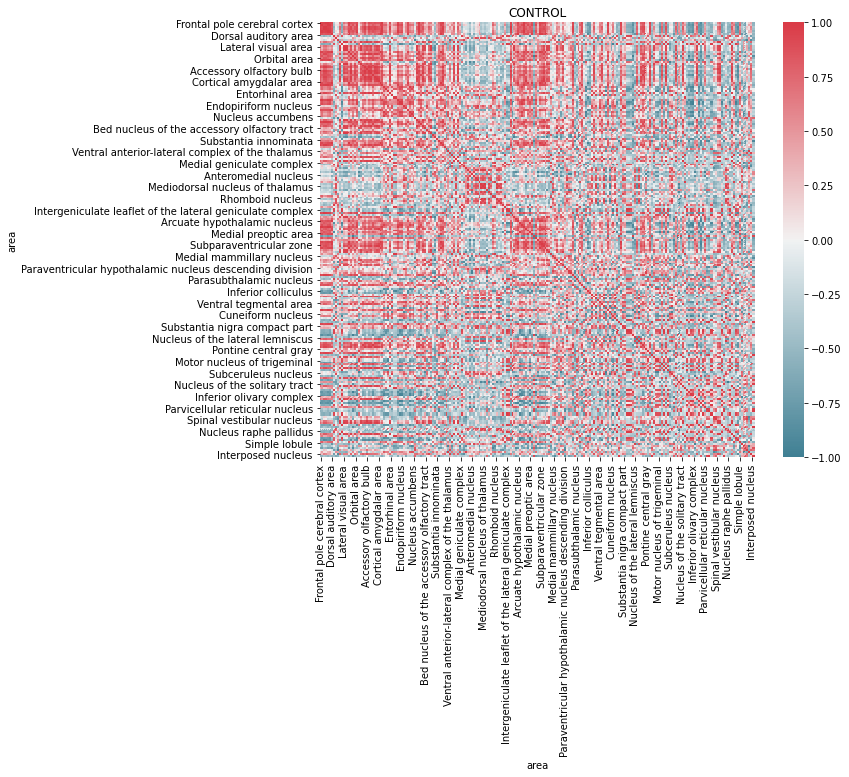

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

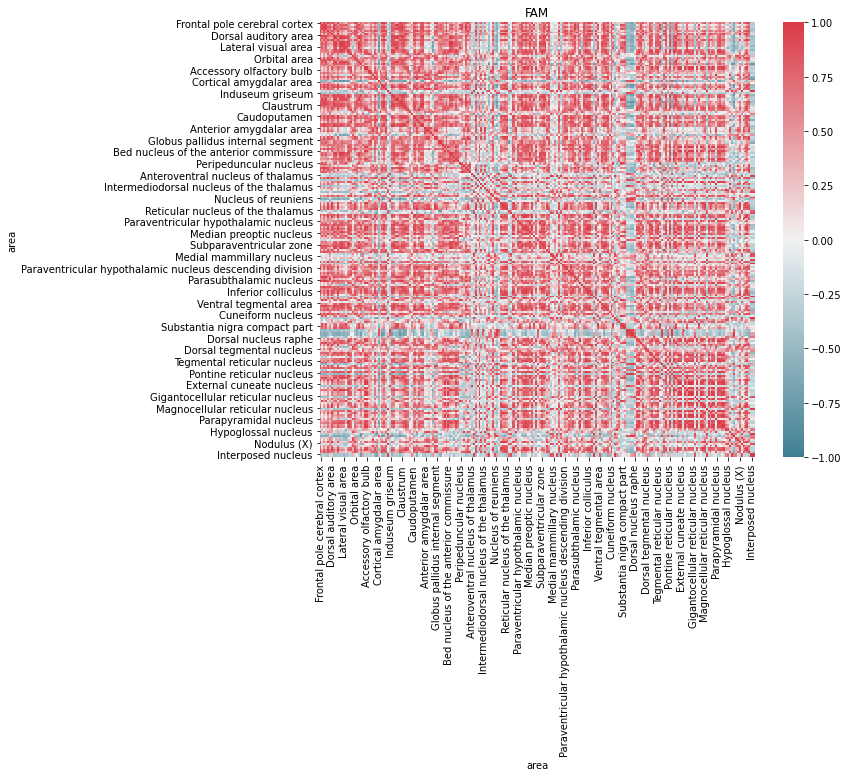

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

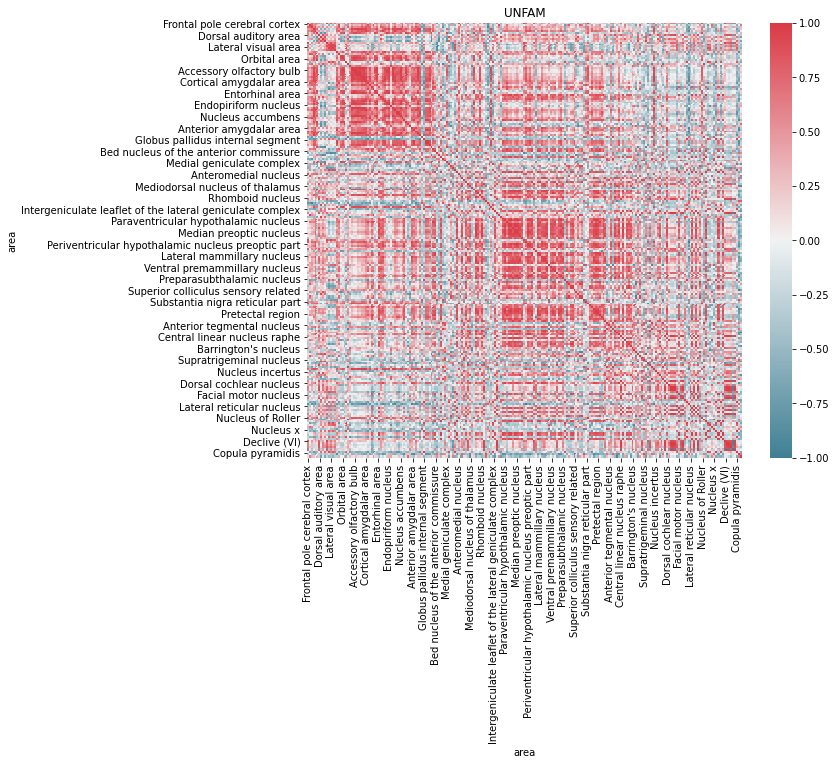

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [46]:
df_control_energy, df_fam_energy, df_unfam_energy = \
calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [50]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0985559,0.42714,0.211058
1,Primary motor area,0.346085,0.211189,0.823022
2,Secondary motor area,0.1596,0.163463,0.822723
3,Primary somatosensory area,0.152076,0.1474,0.852015
4,Supplemental somatosensory area,0.106858,0.127642,0.6025
...,...,...,...,...
293,Flocculus,0.152859,0.332123,0.171183
294,Fastigial nucleus,0.103902,0.103902,NaN
295,Interposed nucleus,0.680584,0.0594587,0.340893
296,Dentate nucleus,0.528656,0.296665,0.340893


In [70]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [71]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.00123886
Parastrial nucleus,0.00254716
Medial amygdalar nucleus,0.00275238
Cortical amygdalar area,0.0030496
Ventral premammillary nucleus,0.00469016
Piriform-amygdalar area,0.00609334
Visceral area,0.0402567
Paraventricular hypothalamic nucleus descending division,0.0533888
Tuberal nucleus,0.0555376


In [53]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.0078592
Globus pallidus internal segment,0.0157394
Ventral premammillary nucleus,0.0165582
Posterior amygdalar nucleus,0.0169529
Piriform-amygdalar area,0.0231406
Cortical amygdalar area,0.0402647
Periventricular hypothalamic nucleus posterior part,0.0527003
Bed nucleus of the anterior commissure,0.0551722
Interposed nucleus,0.0594587


In [54]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.014894
Paraventricular hypothalamic nucleus descending division,0.0282118
Paraflocculus,0.051955
Septohippocampal nucleus,0.0643505
Superior colliculus sensory related,0.0664881
Anterodorsal nucleus,0.105722
Visceral area,0.105855
Posterior hypothalamic nucleus,0.106699
Ventral part of the lateral geniculate complex,0.10842


## Mann-Whitney Test across groups

In [55]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0599231,0.232096,0.148553
1,Primary motor area,0.117667,0.232096,0.34446
2,Secondary motor area,0.117667,0.136115,0.468093
3,Primary somatosensory area,0.0854518,0.232096,0.34446
4,Supplemental somatosensory area,0.0603454,0.291512,0.287587
...,...,...,...,...
293,Flocculus,0.205657,0.5,0.0867427
294,Fastigial nucleus,0.0681901,0.0681901,NaN
295,Interposed nucleus,0.170657,0.024203,0.202328
296,Dentate nucleus,0.446148,0.180655,0.202328


In [56]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0599231,0.232096,0.148553
1,Primary motor area,0.117667,0.232096,0.34446
2,Secondary motor area,0.117667,0.136115,0.468093
3,Primary somatosensory area,0.0854518,0.232096,0.34446
4,Supplemental somatosensory area,0.0603454,0.291512,0.287587
...,...,...,...,...
292,Paraflocculus,0.117667,0.5,0.0327761
293,Flocculus,0.205657,0.5,0.0867427
294,Fastigial nucleus,0.0681901,0.0681901,NaN
295,Interposed nucleus,0.170657,0.024203,0.202328


In [57]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Nucleus z,0.00405656
Accessory abducens nucleus,0.00405656
Pontine reticular nucleus ventral part,0.00405656
Cortical amygdalar area,0.00405656
Efferent vestibular nucleus,0.00405656
Lateral tegmental nucleus,0.00405656
Efferent cochlear group,0.00405656


In [58]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Nucleus circularis,0.00405656
Lateral tegmental nucleus,0.00405656
Lateral strip of striatum,0.00405656
Pontine reticular nucleus ventral part,0.00405656
Superior salivatory nucleus,0.00405656
Substantia nigra lateral part,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Intercollicular nucleus,0.00405656


In [59]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Pineal body,0.00405656
Substantia nigra lateral part,0.00405656
Lateral tegmental nucleus,0.00405656
Pontine reticular nucleus ventral part,0.00405656
Superior salivatory nucleus,0.00405656
Lateral strip of striatum,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Retroethmoid nucleus,0.00405656


## Calculate cross corr matrix across experimental groups on energy

In [72]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

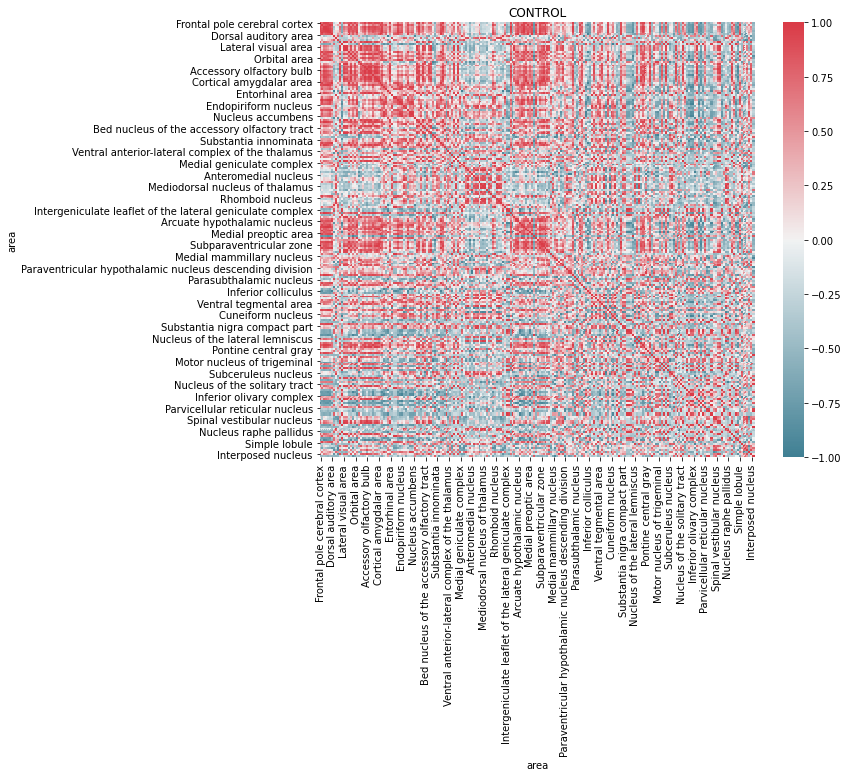

In [63]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

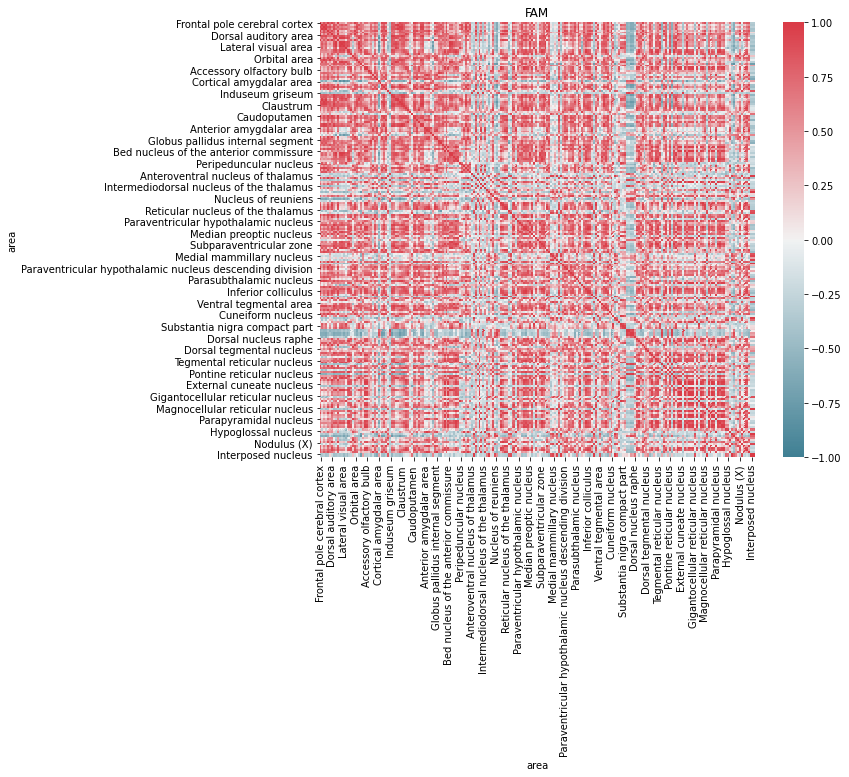

In [64]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

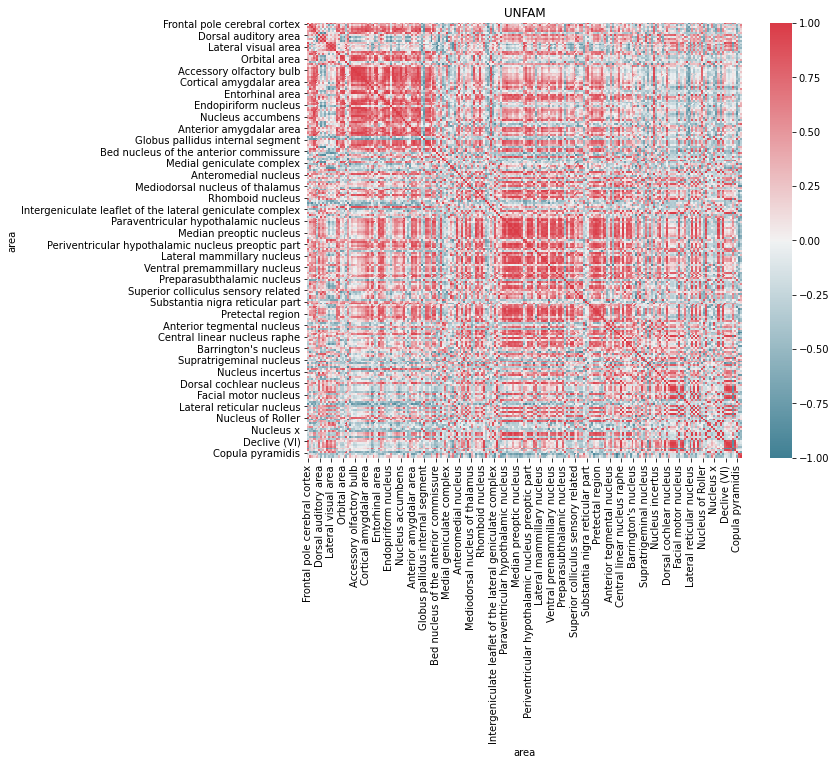

In [65]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')